# Extraemos todas las features del paciente 5   

In [1]:
#Importación de librerías
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne import io
from FVfunctions import getMeData, pot4signals, BANDAS, time2seg, get_interval_range, FIRfilterBP, IIRfilterBS
from features_stats import stats_features
from dataset_reader import get_seizure_events, get_seizure_array
import pickle
from matplotlib.collections import LineCollection

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
import seaborn as sns

from sklearn import datasets
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection as ms

In [2]:
DATASET_DIR = r"../eeg_dataset/physionet.org/files/siena-scalp-eeg/1.0.0/"
edf_names = []
seizure_events = []

for directory in os.listdir(DATASET_DIR):
    print('='*50)
    print(f"{directory: ^50}")
    print('='*50)
    
    for filename in os.listdir(os.path.join(DATASET_DIR, directory)):
        if '.edf' in filename:
            edf_names.append(f"{DATASET_DIR}/{directory}/{filename}")
        elif '.txt' in filename:
            new_seizures = get_seizure_events(f"{DATASET_DIR}/{directory}/{filename}")
            seizure_events.extend(new_seizures)
            for event in new_seizures:
                print('\n'.join([f"{key}: {val}" for key, val in event.items()]))
                print()

print(edf_names)

                       PN01                       
seizure_number: 1
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 21.51.02
seizure_end_time: 21.51.56

seizure_number: 2
file_name: PN01-1.edf
registration_start_time: 19.00.44
registration_end_time: 08.29.41
seizure_start_time: 07.53.17
seizure_end_time: 07.54.31

                       PN05                       
seizure_number: 2
file_name: PN05-2.edf
registration_start_time: 06.46.02
registration_end_time: 09.19.47
seizure_start_time: 08.45.25
seizure_end_time: 08.46.00

seizure_number: 3
file_name: PN05-3.edf
registration_start_time: 06.01.23
registration_end_time: 08.06.57
seizure_start_time: 07.55.19
seizure_end_time: 07.55.49

seizure_number: 4
file_name: PN05-4.edf
registration_start_time: 06.38.35
registration_end_time: 08.00.23
seizure_start_time: 07.38.43
seizure_end_time: 07.39.22

                       PN09                       
seizure_number: 1
file_name: PN0

In [3]:
channels = ['EEG T3', 'EEG T5', 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
segments = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]
        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6
    
        # Paso 3: sacamos segmentos
        
        for i in range(len(channels)):
            new_seg, new_label = getMeData(data_namefilt[i], 
                                        mtx_t_reg, 
                                        arr_mtx_t_epi, 
                                        winlen=2, 
                                        proportion=0.5)
            segments.append(new_seg)
            labels.append(new_label)
        

segments_arr = np.concatenate(segments)
labels_arr = np.concatenate(labels)

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_

In [4]:
segments_arr.shape

df_seg = pd.DataFrame(data=segments_arr)

df_seg['label'] = labels_arr
df_seg.to_csv('seg_wl2_p05.csv', sep=',', encoding='utf-8')

In [5]:
df_seg

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,-4.472829,-3.154045,-4.053592,-6.366900,-6.988457,-4.328618,-0.730178,-0.454550,-5.226451,-12.174300,...,-17.940607,-15.412079,-14.003189,-13.690342,-14.067557,-14.373877,-13.701598,-11.499967,-8.029322,1.0
1,-9.922048,-15.293200,-19.140436,-20.414215,-19.014289,-16.234338,-14.167458,-14.160037,-15.690225,-16.951606,...,-8.739059,-12.962622,-15.510053,-15.901656,-14.992681,-13.853433,-12.858757,-11.801654,-10.581027,1.0
2,-10.250642,-9.155654,-8.571189,-8.428121,-8.341408,-8.176987,-8.185278,-8.494234,-8.710740,-8.317696,...,-27.240703,-33.757470,-38.792932,-40.124220,-37.758935,-33.522737,-29.492660,-26.685243,-24.766862,1.0
3,-25.157702,-24.061029,-21.794725,-18.060307,-13.623291,-9.803282,-7.678063,-7.579465,-9.090453,-11.291964,...,23.642128,15.955108,0.216419,-13.286746,-13.021186,1.017556,16.438408,20.513854,12.763516,1.0
4,12.866805,-4.506496,-14.992573,-18.980742,-23.399450,-32.501793,-41.983658,-43.619942,-35.108785,-23.589719,...,31.229097,32.718547,30.177225,27.506629,29.202241,34.797358,38.592657,35.202808,25.267992,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6937,6.602806,-3.950222,-8.972830,-8.173071,-6.094107,-6.807966,-10.030167,-12.664594,-13.055379,-12.401964,...,-0.792796,-3.372985,-3.789165,-1.740927,0.801086,2.003992,1.933881,1.851120,2.303703,0.0
6938,-4.784362,-6.120780,-5.049044,-0.372063,6.778601,12.834207,14.282446,11.208607,7.934665,9.081548,...,31.534699,26.929698,23.253374,22.229735,24.330467,28.646832,33.562569,37.883134,41.641388,0.0
6939,-17.479688,-20.946240,-24.892834,-28.086776,-28.219029,-24.846298,-20.814085,-20.073870,-23.972711,-29.974526,...,-41.277611,-40.435458,-43.783998,-48.434454,-50.335498,-47.826263,-42.709096,-37.863194,-34.114372,0.0
6940,-3.997546,-2.088530,-1.993298,-4.347713,-8.622439,-12.769539,-14.326422,-12.498036,-9.081603,-6.913359,...,26.307706,40.450468,36.534742,17.542257,-3.349362,-14.990283,-15.653061,-10.444569,-4.238806,0.0


In [6]:
# Potencia
more_pot = pot4signals(segments_arr, fs, divisor=1, tipo="relativa")
pot_names = [f"potRel{band.capitalize()}" for band in BANDAS.keys()]

# Estadistica
stat_data = stats_features(segments_arr)
stats_names = list(stat_data.values())[:-1]
more_stat = stat_data["matriz de features stat"]

# Feature fector
data_fv = np.hstack((more_pot, more_stat))
columnas = pot_names + stats_names
df_fv = pd.DataFrame(data_fv, columns=columnas)
df_fv

,potRelDelta,potRelTheta,potRelAlpha,potRelBeta,potRelGamma,kurtosis,RMS,skewness,media,desvio estandar
0,0.569224,0.151885,0.071706,0.113895,0.093290,3.156318,13.951921,-1.471574,-7.274275,11.905504
1,0.320815,0.177400,0.089705,0.224173,0.187907,-0.105051,20.263972,-0.341136,-4.721904,19.706146
2,0.005102,0.955709,0.031362,0.005942,0.001886,-0.451693,33.084309,-0.234021,-2.184331,33.012122
3,0.008167,0.918208,0.030295,0.031559,0.011771,-0.862544,46.699844,-0.317577,-2.866577,46.611781
4,0.029423,0.908807,0.054490,0.003708,0.003572,-1.159238,63.985770,-0.323435,-1.132473,63.975747
...,...,...,...,...,...,...,...,...,...,...
6937,0.486086,0.273952,0.110537,0.078245,0.051180,2.731273,10.748558,-1.414452,-2.516438,10.449834
6938,0.782160,0.069675,0.034999,0.055993,0.057173,1.447766,42.478098,-1.165124,39.147010,16.489402
6939,0.554322,0.305228,0.050155,0.043082,0.047213,0.544198,35.504945,-1.088787,-31.365513,16.637478
6940,0.423628,0.264300,0.028792,0.126682,0.156598,5.413719,15.852224,-1.279880,-1.372870,15.792664


# MACHINE LEARNING

In [11]:
train_x, test_x, train_y, test_y = train_test_split(df_fv, labels_arr, test_size=0.2, random_state=0)

alpha_star = 0.515000000000001


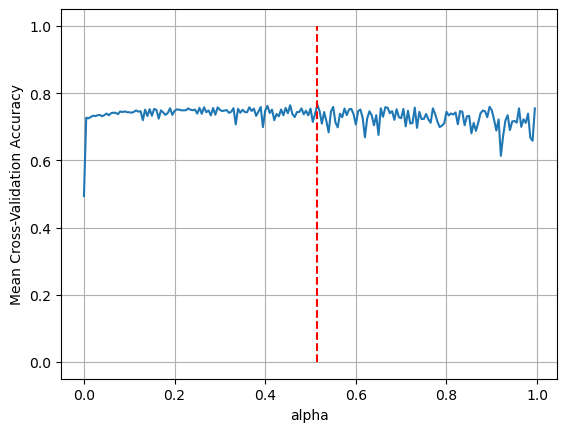

In [12]:
C = np.arange(1e-15,1,0.005) # Range of hyperparameter values 1E-15 to 1 by 0.005
val_scores = np.zeros((len(C),1)) # Initialize validation score for each alpha value


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(C)): # for each alpha value
        # Set up SVM with hinge loss and l2 norm regularization
        model = LinearSVC(dual=True,C=C[i])
        
        #linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=alpha[i])
        
        # Calculate cross validation scores for 5-fold cross-validation
        score = ms.cross_val_score(model, df_fv, labels_arr, cv=5)
        val_scores[i] = score.mean() # Calculate mean of the 5 scores

# Determine the alpha that maximizes the cross-validation score
ind = np.argmax(val_scores)
C_star = C[ind]
print('alpha_star =', C_star)

# Plot accuracy
plt.plot(C,val_scores)
plt.plot(np.ones(11)*C_star,np.arange(0,1.1,0.1),'--r')
plt.xlabel('alpha')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)
plt.show()

0.7645788336933045


c:\Users\lucas\miniconda3\envs\venvpsib\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Axes: >

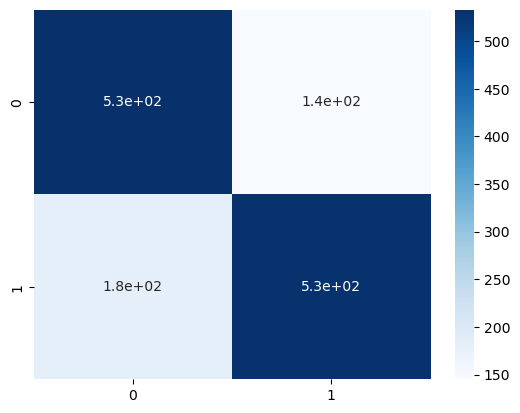

In [13]:
# testeamos en un modelo lineal
linear_model = LinearSVC(dual=True,max_iter=2000,C=C_star)
linear_model.fit(train_x, train_y)
predictions = linear_model.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)
sns.heatmap(cm, cmap='Blues', annot=True)

0.734341252699784


<Axes: >

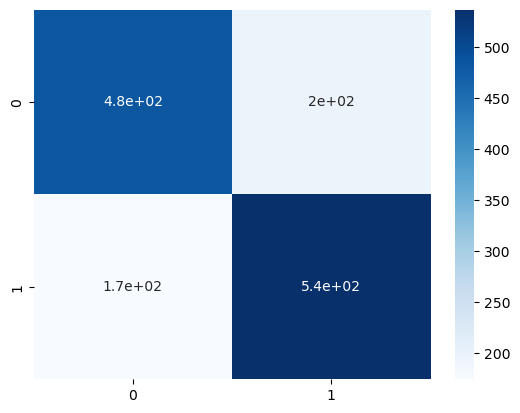

In [14]:
# kernel
rbf_model = SVC(kernel='rbf')
rbf_model.fit(train_x, train_y)
rbf_pred = rbf_model.predict(test_x)
print(accuracy_score(test_y, rbf_pred))
cm_rbf = confusion_matrix(test_y, rbf_pred)
sns.heatmap(cm_rbf, annot=True, cmap='Blues')

In [56]:
with open(), 'wb') as file:
    pickle.dump(linear_model, file)

0.7465802735781137


Text(50.72222222222221, 0.5, 'True label')

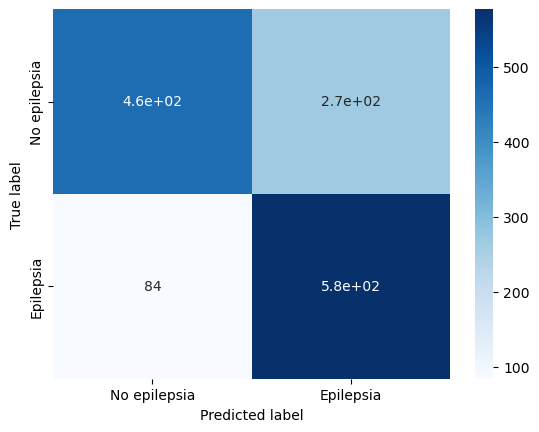

In [59]:
with open('Linear_SVC_wl_2_ALL.pkl', 'rb') as file:
    modelo_leido = pickle.load(file)

clasificaciones = ["No epilepsia","Epilepsia"]


predictions = modelo_leido.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)

cm_df = pd.DataFrame(data=cm,index=clasificaciones,columns=clasificaciones)

ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# LUKITESTING

In [8]:
modelos = []
scores = []

iteraciones = 100

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(iteraciones):
        linear_model = LinearSVC(dual=True,max_iter=2000)
        linear_model.fit(train_x, train_y)
        predictions = linear_model.predict(test_x)
        score = accuracy_score(test_y, predictions)
        
        modelos.append(linear_model)
        scores.append(score)
        
arr_n = np.arange(len(scores))

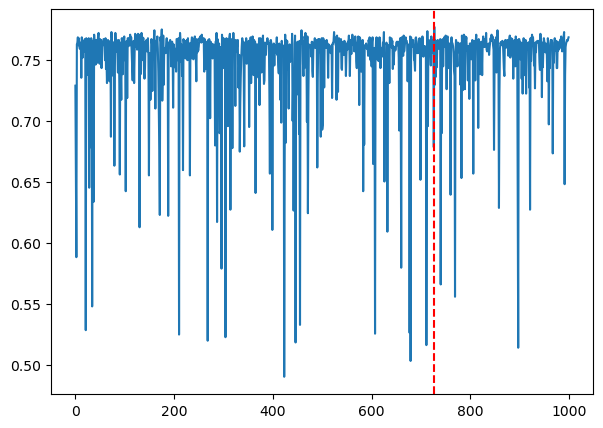

In [9]:
ind = np.argmax(scores)
n = arr_n[ind]

plt.figure(figsize=(7,5))
plt.plot(arr_n,scores)
plt.axvline(x=n,linestyle="--",color="red")
plt.show()



0.7768178545716342


Text(50.72222222222221, 0.5, 'True label')

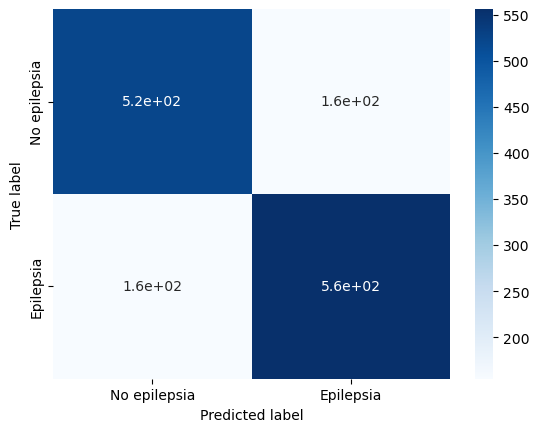

In [10]:
ind = np.argmax(scores)
modelo_star = modelos[ind]

predictions = modelo_star.predict(test_x)
print(accuracy_score(test_y, predictions))
cm = confusion_matrix(test_y, predictions)

clasificaciones = ["No epilepsia","Epilepsia"]
cm_df = pd.DataFrame(data=cm,index=clasificaciones,columns=clasificaciones)

ax = sns.heatmap(cm_df, cmap='Blues', annot=True)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# LUKITESTING - PT.2 - ML para segmentar EEGs

In [5]:
with open('lukimodel_LinSVC_wl2_AllCh', 'rb') as file:
    modelo_leido = pickle.load(file)

In [15]:
modelo_leido = modelo_star

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN01\PN01-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 1 1]


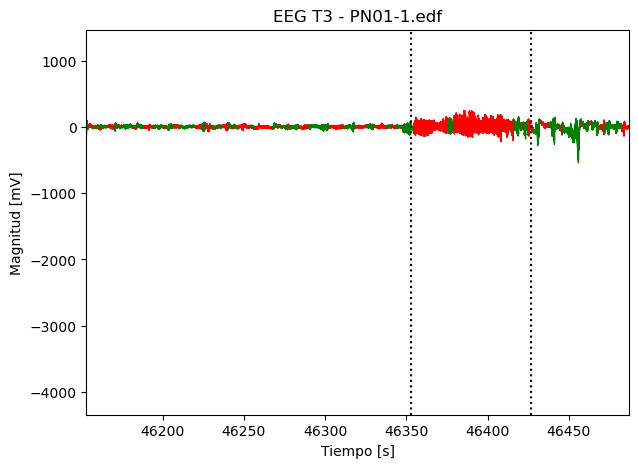

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 1 ... 0 0 0]


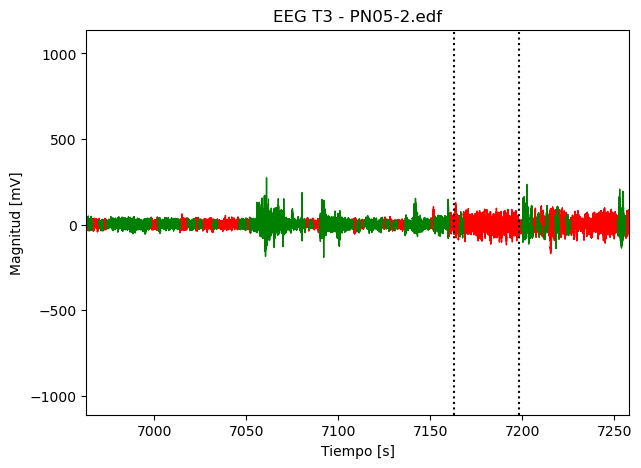

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[1 0 0 ... 0 0 0]


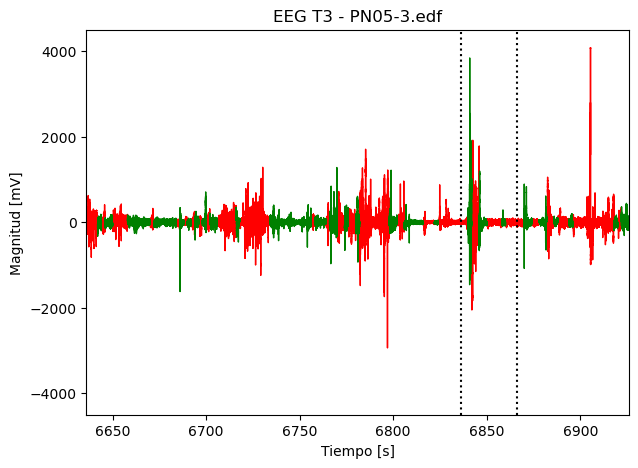

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN05\PN05-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 0 0]


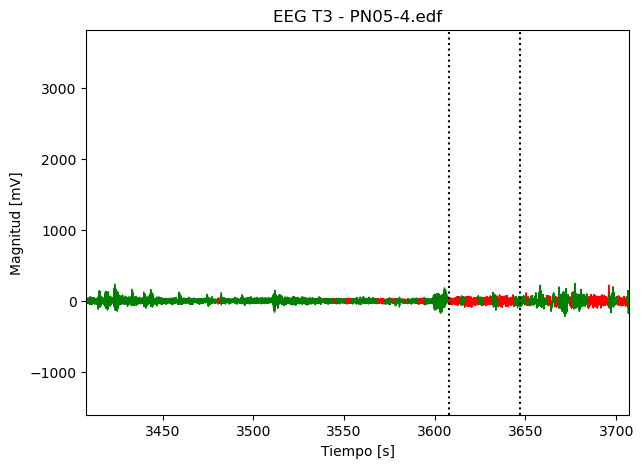

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN09\PN09-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 0 0]


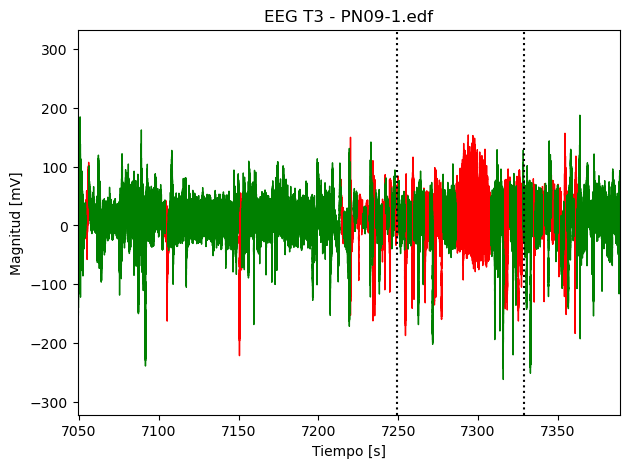

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN09\PN09-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 0 0]


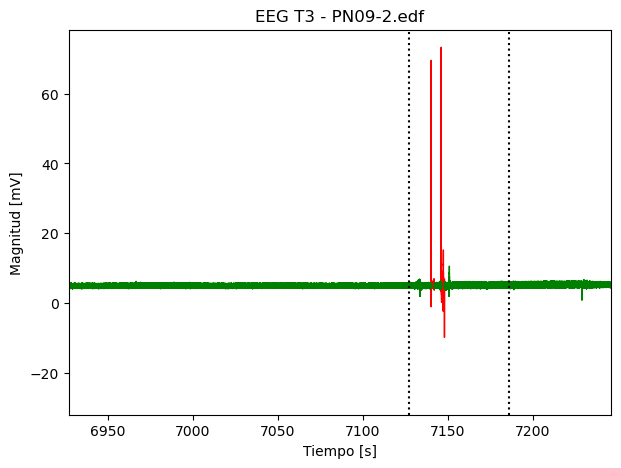

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN09\PN09-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 0 0]


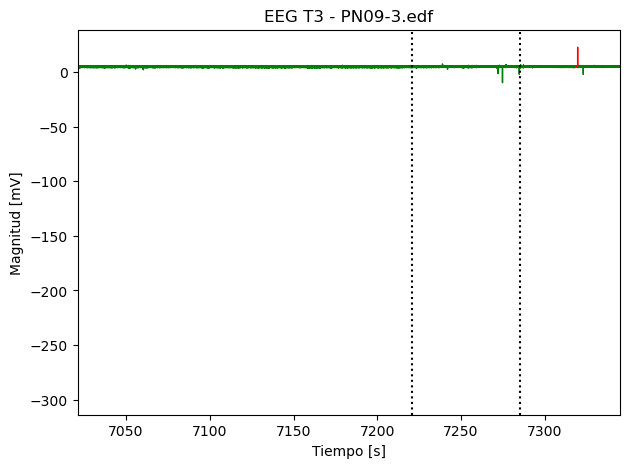

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN12\PN12-1.2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 0 0 1]


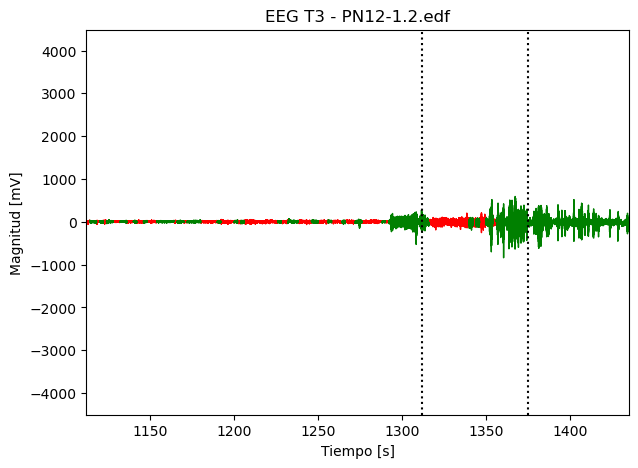

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN12\PN12-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 0 0 0 0 1 0 0 

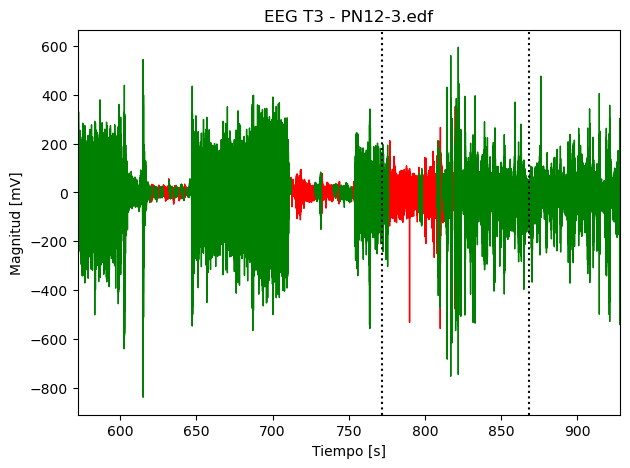

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN12\PN12-4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 1 0 ... 0 0 0]


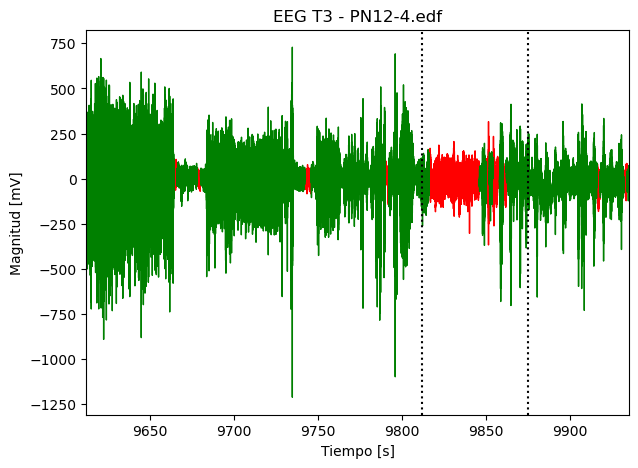

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN13\PN13-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 1 ... 1 0 1]


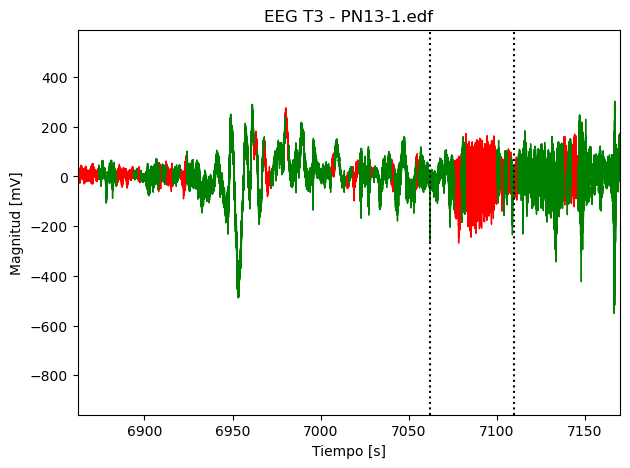

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN13\PN13-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[1 1 1 ... 0 0 0]


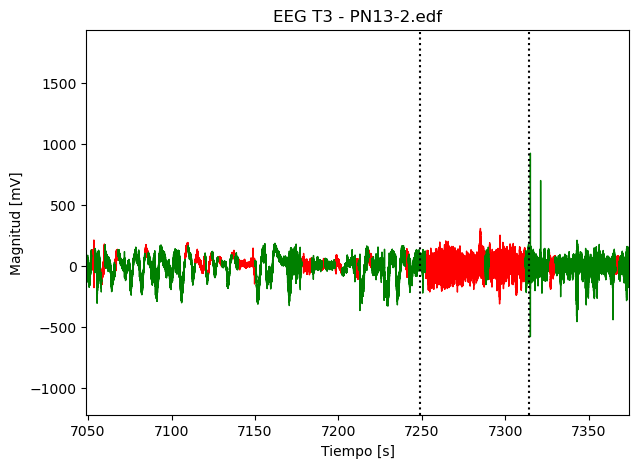

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN13\PN13-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[1 1 0 ... 1 1 1]


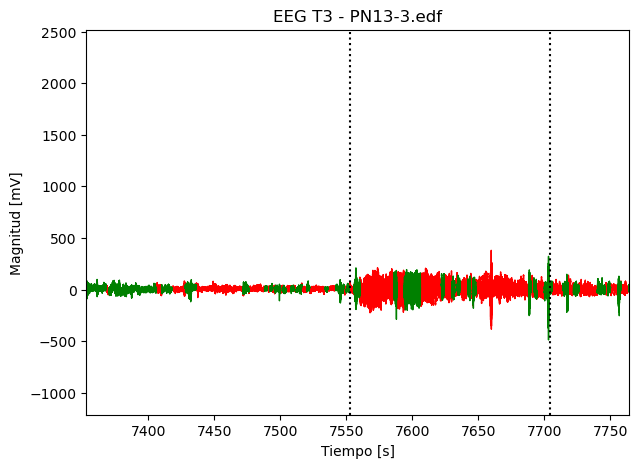

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN16\PN16-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[1 0 1 ... 1 1 1]


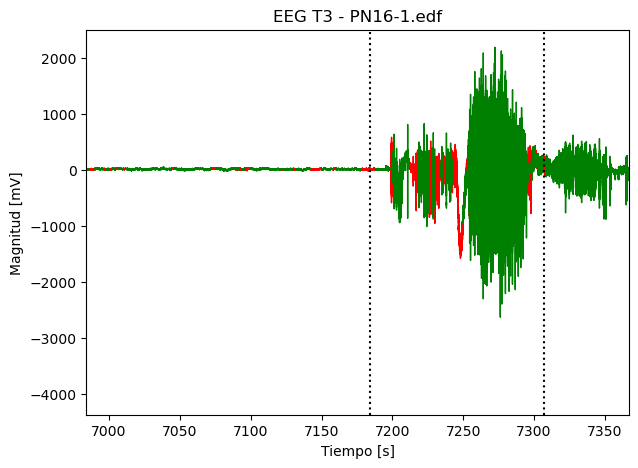

Extracting EDF parameters from c:\Users\lucas\Documents\03-TPFINAL-PSIB\eeg_dataset\physionet.org\files\siena-scalp-eeg\1.0.0\PN16\PN16-2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



[0 0 0 ... 1 0 1]


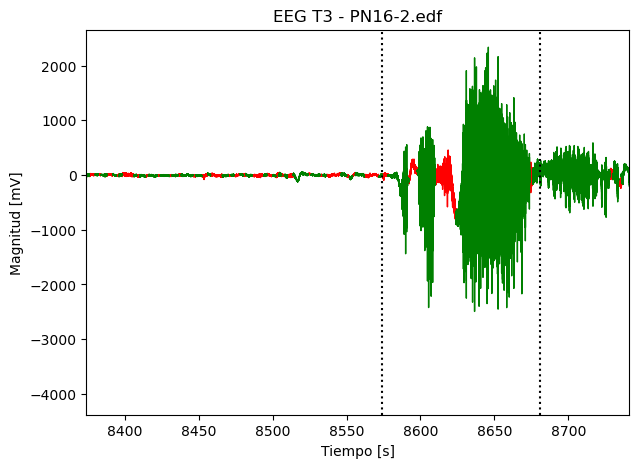

In [17]:
channels = ['EEG T3', 'EEG T5', 'EEG F7', 'EEG F3', 'EEG C3', 'EEG P3']
indexes = []
labels = []
fs = None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for edf in edf_names:
        # Paso 1: duracion de señal y seizures
        name = edf.split('/')[-1]
        this_seizure_events = [seiz for seiz in seizure_events if seiz["file_name"]==name]
        
        if len(this_seizure_events) == 0:
            print('nada en', name)
            continue
            
        ex_seiz = this_seizure_events[0]
        mtx_t_reg = np.array([ex_seiz['registration_start_time'], ex_seiz['registration_end_time']])
        arr_mtx_t_epi = get_seizure_array(this_seizure_events)
    
        # Paso 2: extraemos la señal
        raw = io.read_raw_edf(edf)
        print('\n\n')
        if fs is None:
            fs = raw.info['sfreq']
        raw_filt = raw.pick(channels)
        data_namefilt = raw_filt.get_data() * 1e6

        
        
        ###################
        ###################
        ###################
        
        
        #Array de instantes
        start = 0
        stop = (1/fs)*len(data_namefilt[0])
        arr_t = np.arange(start=start,stop=stop,step=(1/fs))
        
        # 1: Se determinan los índices iniciales de los segmentos
        t_reg_start =   time2seg(time=mtx_t_reg[0],ref_time=mtx_t_reg[0])
        t_reg_end   =   time2seg(time=mtx_t_reg[1],ref_time=mtx_t_reg[0])
        indexes     =   np.uint32(get_interval_range(t_reg_start, t_reg_end, fs, winlen=2))

        #2: Se seleccion la señal que se quiere analizar
        sig = data_namefilt[0]
        step = int(fs*2)
        
        #3: Se obtienen los segmentos, tanto de la señal como del array de instantes
        arr_seg_sig = np.array([sig[idx:(idx + step)] for idx in indexes])
        arr_seg_t   = np.array([arr_t[idx:(idx + step)] for idx in indexes])

        #4: Se filtran los segmentos de señal
        arr_filtered_seg_sig = FIRfilterBP(arr_seg_sig)
        arr_filtered_seg_sig = IIRfilterBS(arr_filtered_seg_sig)
        
        #5: Se determinan los fv de estos segmentos
        
        #5.1: Potencia
        more_pot = pot4signals(arr_filtered_seg_sig, fs, divisor=1)
        pot_names = [f"potRel{band.capitalize()}" for band in BANDAS.keys()]

        #5.2: Estadistica
        stat_data = stats_features(arr_filtered_seg_sig)
        stats_names = list(stat_data.values())[:-1]
        more_stat = stat_data["matriz de features stat"]

        #5.3: Feature vector
        data_fv = np.hstack((more_pot, more_stat))
        columnas = pot_names + stats_names
        df_fv = pd.DataFrame(data_fv, columns=columnas)
        
        #6: Se predicen las labels con el modelo
        predictions = np.uint8(modelo_leido.predict(df_fv))
        print(predictions)
        
        #7: A partir de las labels predecidas se arman 2 'line_collection'
        
        #7.1: Líneas true
        arr_lineas_true = [np.column_stack((arr_seg_t[i],arr_seg_sig[i])) for i in range(len(predictions)) if predictions[i]==1] 
        line_collection_true = LineCollection(arr_lineas_true, colors="red",linewidths=1)
        
        #7.2: Líneas false
        arr_lineas_false = [np.column_stack((arr_seg_t[i],arr_seg_sig[i])) for i in range(len(predictions)) if predictions[i]==0] 
        line_collection_false = LineCollection(arr_lineas_false, colors="green",linewidths=1)
        
        #8: Ploteo de los segmentos
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.add_collection(line_collection_true)
        ax.add_collection(line_collection_false)
        
        for i in range(len(arr_mtx_t_epi)):
            # 1.0- Obtención de instantes característicos del ataque epiléptico
            mtx_inst = arr_mtx_t_epi[i]

            t_epi_start =   time2seg(time=mtx_inst[0],ref_time=mtx_t_reg[0])
            t_epi_end   =   time2seg(time=mtx_inst[1],ref_time=mtx_t_reg[0])

            plt.axvline(x=t_epi_start,linestyle=":",color="black")
            plt.axvline(x=t_epi_end,linestyle=":",color="black")
        
        plt.xlim((t_epi_start-200,t_epi_end+60))
        plt.title(f"{channels[0]} - {name}")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Magnitud [mV]")
        ax.autoscale_view()
        plt.show()
        
        
        

In [20]:
predictions = modelo_leido.predict(test_x)